In [10]:
import toml
import joblib
import numpy as np
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
from os.path import join
from rl_analysis import ANALYSIS_CONFIG
from rl_analysis.behavior.moseq import syll_onset
from rl_analysis.io.df import dlight_exclude_toml, NONSYLL_COLS
from rl_analysis.plotting import fg, save_factory, setup_plotting_env, clean_ticks, add_legend
from rl_analysis.photometry.windowing import window_trials_as_df

In [2]:
sorting = joblib.load("/home/wg41/reinforcement_data/dlight_photometry/fig1-syllable-sorting.p")

In [3]:
with open(ANALYSIS_CONFIG, 'r') as f:
    config = toml.load(f)

In [4]:
setup_plotting_env()

saver = save_factory(join(config['figures']['dir_wg'], 'variability-fig'), tight_layout=False)

plt.rcParams['figure.dpi'] = 300

In [5]:
use_dct = dlight_exclude_toml(
    "/home/wg41/reinforcement_data/_proc_photometry_dlight/dlight_photometry_processed_full.toml",
    **config["dlight_common"]
)

In [6]:
df = pd.read_parquet(
    config['intermediate_results']['dlight_public'],
    filters=[("uuid", "in", list(use_dct)), ("area", "=", "dls")],
)

df = df[~df["session_number"].isin([3, 4])]
df = df.drop(columns=NONSYLL_COLS)
df = df.sort_index()

df["offline onset"] = False
df.loc[df.index[syll_onset(df["predicted_syllable (offline)"])], "offline onset"] = True

In [7]:
feat_df, trial_df = window_trials_as_df(
    df,
    np.where(df["offline onset"])[0],
    "signal_reref_dff",
    agg_window=(0, 0.3),
    avg_window=(0, 0.3),
    zscore_signal=False,
)

feat_df["uuid"] = df.iloc[feat_df["trial_index"]]["uuid"].reset_index(drop=True)

In [8]:
quant_range = 0.99
edges = np.histogram_bin_edges(
    feat_df["max"].dropna(),
    bins=75,
    range=(-0.025, feat_df["max"].quantile(quant_range)),
)
x = edges[:-1] + (np.diff(edges) / 2)

dists = []
avgs = []
for syll in sorting:
    tmp = feat_df.loc[feat_df["labels"] == syll, "max"]
    dist, _bins = np.histogram(tmp, edges, density=True)
    dists.append(dist)
    avgs.append(tmp.mean())

dists = np.array(dists)

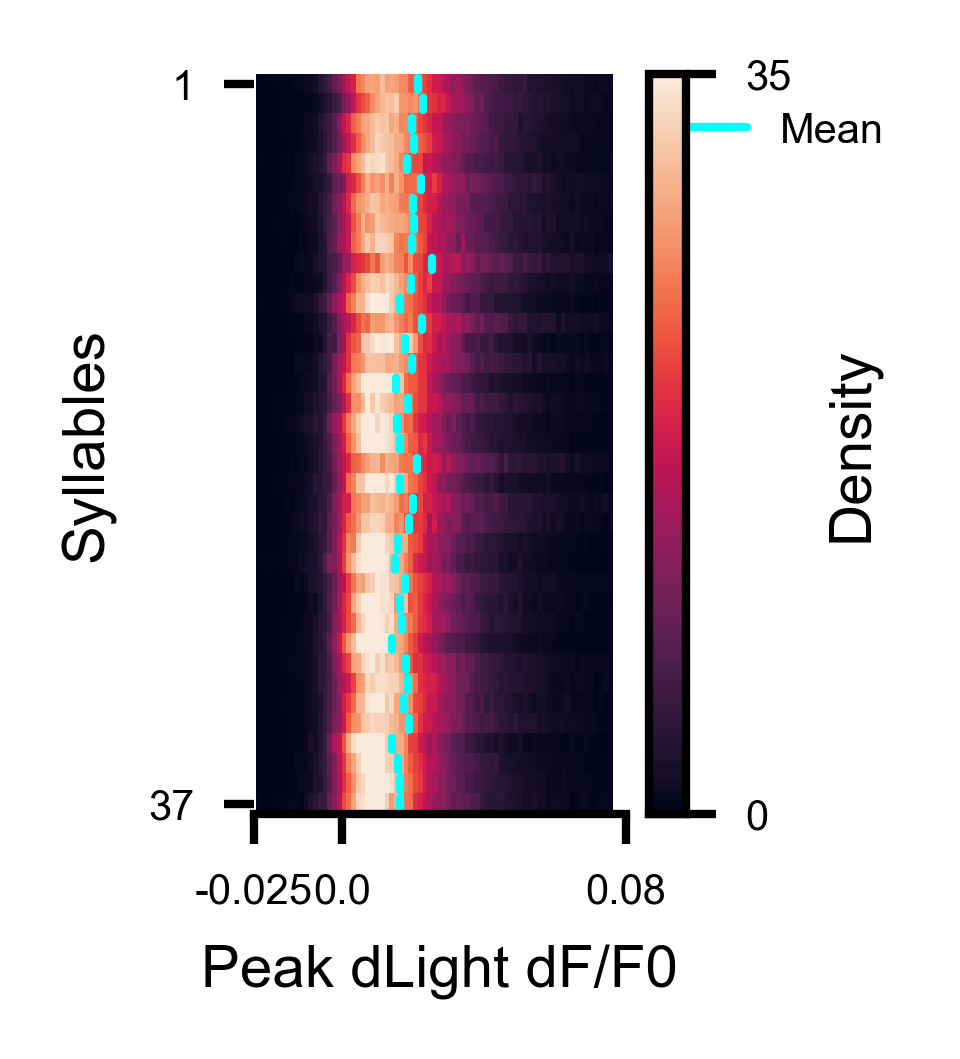

In [13]:
pad = 0.2
fig = fg(1, 1.6)
fig.dpi = 300
ax = fig.gca()
im = ax.imshow(
    dists, aspect="auto", extent=(x[0], x[-1], len(sorting), 0), vmax=35, interpolation="none"
)
cb = fig.colorbar(im, ax=ax, label="Density")
cb.set_ticks([0, 35])
for i in range(len(avgs)):
    plt.plot((avgs[i],) * 2, (i + pad, i + (1 - pad)), lw=1, c="cyan", label='Mean' if i == 0 else None)
ax.set(
    xlabel="Peak dLight dF/F0",
    ylabel="Syllables",
    yticks=[0.5, len(sorting) - 0.5],
    yticklabels=[1, len(sorting)],
    ylim=(len(sorting), 0),
    xlim=(-0.025, 0.08),
)
clean_ticks(ax, axis="x", zero_symmetry=False, precision=3)
sns.despine(left=True)
add_legend(ax)
saver(fig, "prob-density-of-raw-dlight-instances");